In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt
from pair_trading_foundations.data_generation import ExecutePairTrading, generate_training_data
random.seed(23)
import cProfile
import pstats
import pickle
import plotly.express as px
from time import time
import warnings
warnings.filterwarnings('ignore')

def chunker(seq, size):
    # split a list into chunks
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

/tmp/ipykernel_4078/4155852776.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# data = pd.read_csv('Data/sp500_full_20181231_to_20231229.csv')
data = pd.read_csv('Data/sp500_full_19991201_to_20231231.csv')
value_count_tb = data[['Ticker']].groupby('Ticker').size().reset_index()
value_count_tb.columns = ['Ticker', 'Count']
stock_to_keep = value_count_tb['Ticker'][value_count_tb.Count==value_count_tb.Count.max()]
data = data[data.Ticker.isin(stock_to_keep)]

# Generate for all pairs

In [3]:
tickers = list(set(data.Ticker.values))
combinations = list(itertools.combinations(tickers, 2))
len(combinations)
batches = list(chunker(combinations, 1000))

In [4]:
len(data)

2169122

In [7]:
from importlib import reload
import pair_trading_foundations.data_generation
reload(pair_trading_foundations.data_generation)
from pair_trading_foundations.data_generation import ExecutePairTrading, generate_training_data

i = 0
for batch in batches:
    start_ts=time()
    print(f'Getting {i+1}th out of {len(batches)} batches')
    max_pairs = 1
    features_tb, labels_tb = generate_training_data(
        data=data,
        moving_average=60,
        training_len=300,
        test_len=60,
        entry_signal=2,
        exit_signal=0.5,
        calculate_label=True,
        verbose=False,
        max_combinations=max_pairs,
        combinations=batch
    )
    combined = pd.merge(features_tb, labels_tb, how='left', on=['Date', 'Ticker_P1','Ticker_P2']).reset_index(drop=True)
    combined = combined[combined.pnls.notnull()].reset_index(drop=True)
    combined.to_csv(f'Data/Training/pair_features_{i+1}_pairs{max_pairs}_300_120.csv', index=False)
    end_ts = time()
    print(f"Took {end_ts - start_ts} seconds")
    i+=1
    break
    
len(combined)
combined

Getting 1th out of 64 batches
1000 stock pairs detected
Took 0.511110782623291 to initilize. Entering ticker pair loop
Max combination = 1
Took 10.505067110061646 to finish
Took 10.603912353515625 seconds


,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,REG,2001-02-09 00:00:00,24.049999,23.910000,16100.0,8.681872,COO,4.838750,4.801250,883200.0,4.716492,3.965381,3.308248,0.463729,3.778665,0.299155,0.061554,3.572825,0.312126
1,REG,2001-02-12 00:00:00,24.500000,24.000000,44400.0,8.885213,COO,4.868750,4.712500,1195200.0,4.630737,4.254476,3.310837,0.466837,3.795088,0.297752,0.050275,3.561249,0.299245
2,REG,2001-02-13 00:00:00,24.469999,23.900000,47600.0,8.732707,COO,4.780000,4.531250,1394400.0,4.440852,4.291855,3.313653,0.470197,3.808593,0.301641,0.050429,3.549392,0.283755
3,REG,2001-02-14 00:00:00,24.350000,23.930000,51600.0,8.769017,COO,4.575000,4.362500,2244000.0,4.322020,4.446998,3.317519,0.474725,3.825297,0.308817,0.000000,3.535962,0.258937
4,REG,2001-02-15 00:00:00,24.280001,23.799999,129800.0,8.743600,COO,4.512500,4.425000,1223200.0,4.377148,4.366452,3.321491,0.478497,3.841411,0.311441,0.000000,3.523079,0.235462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5693,REG,2023-09-28 00:00:00,60.290001,59.400002,1255700.0,59.483173,COO,80.077499,79.029999,1928000.0,79.842499,20.359325,25.431160,8.418816,30.219917,4.925189,0.000000,22.198984,1.842516
5694,REG,2023-09-29 00:00:00,60.820000,59.160000,1083300.0,58.820156,COO,81.135002,79.332497,1246000.0,79.502502,20.682346,25.434090,8.417003,30.011175,5.060014,0.000000,22.304820,1.932540
5695,REG,2023-10-02 00:00:00,59.560001,57.689999,736100.0,57.464443,COO,79.400002,77.425003,1311200.0,77.974998,20.510555,25.437949,8.414471,29.777515,5.170295,0.000000,22.428477,2.047716
5696,REG,2023-10-03 00:00:00,57.900002,56.290001,885500.0,56.395710,COO,78.525002,77.297501,1178800.0,78.227501,21.831791,25.447208,8.408949,29.545609,5.209945,0.000000,22.518531,2.136385


count    5738.000000
mean        0.000979
std         0.025560
min        -0.198545
25%         0.000000
50%         0.000000
75%         0.000000
max         0.310565
Name: pnls, dtype: float64

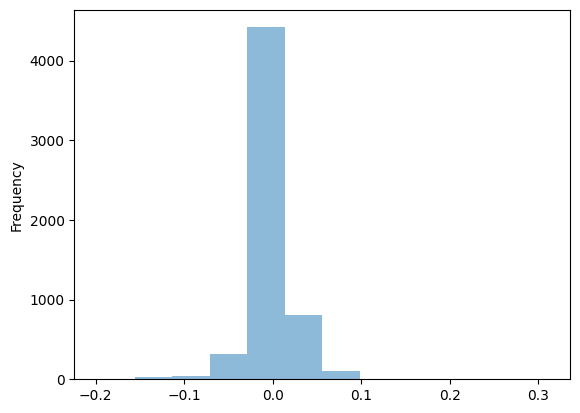

In [6]:
labels_tb
labels_tb = labels_tb.dropna()
labels_tb.pnls.plot.hist(bins=12, alpha=0.5)
labels_tb.pnls.describe()